# Comparison of NGCAS vs. galSVM results on a single image

In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load IRAF morpho catalogue

In [2]:
data_iraf = pd.read_csv('../catalogs/ngcas_out_1564.txt',
                        delim_whitespace=True, header=None, skiprows=1,
                        names=['ID', 'x', 'y',
                               'c', 'e_c', 'a', 'e_a', 's', 'e_s', 'm20', 'gini',
                               'petr', 'halfradius', 'flux', 'inflag', 'casflag'])

In [3]:
data_iraf.describe()

ID            x            y            c          e_c  \
count  1565.0000  1565.000000  1565.000000  1565.000000  1565.000000   
mean    782.0000    50.974700    50.969942     2.725970     0.277827   
std     451.9209     1.548548     1.535753     0.730345     0.071572   
min       0.0000    45.501000    45.531000     1.167000     0.057000   
25%     391.0000    51.324000    51.310000     2.373000     0.231000   
50%     782.0000    51.467000    51.464000     2.737000     0.273000   
75%    1173.0000    51.613000    51.603000     3.171000     0.319000   
max    1564.0000    52.188000    52.288000     5.313000     0.443000   

                 a          e_a            s          e_s          m20  \
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000   
mean      0.149854     0.027243     0.023976     0.000284    -1.659157   
std       0.205252     0.036795     0.065140     0.000781     0.668236   
min      -6.530000     0.000000    -0.070000     0.000000    -5.810000   
25%       0.085000     0.009000     0.000000     0.000000    -1.960000   
50%       0.147000     0.020000     0.000000     0.000000    -1.770000   
75%       0.221000     0.036000     0.000000     0.000000    -1.590000   
max       0.788000     0.811000     0.750000     0.007000     0.000000   

              gini         petr   halfradius         flux  inflag      casflag  
count  1565.000000  1565.000000  1565.000000  1565.000000    1565  1565.000000  
mean      0.805102    12.550440     3.456403    58.795673       0     1.396805  
std       3.174994     6.971604     1.871227   181.351774       0     1.402087  
min     -24.830000     4.446000     1.087000     5.422000       0     1.000000  
25%       0.616000     7.577000     2.152000    11.053000       0     1.000000  
50%       0.654000    10.690000     3.294000    19.901000       0     1.000000  
75%       0.697000    15.246000     4.432000    43.866000       0     1.000000  
max      97.926000    56.107000    16.933000  4047.400000       0     7.000000

Let's first focus on the `(x, y)` position. The quantiles seem to suggest a high concentration of data around 51.5 in both values.

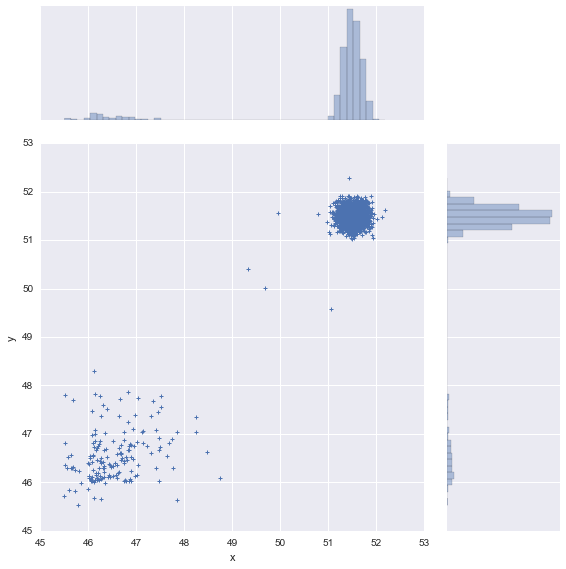

In [4]:
pos = sb.jointplot(x='x', y='y', data=data_iraf, stat_func=None, 
                   s=10, linewidth=1, marker='+',
                   size=8, ratio=3)

The bottom left values seem really off. They are maybe flagged in the catalog.

There are two flags in the output catalog, `inflag` and `casflag`. While `inflag` value is always 0, `casflag` appears to take several values.

Let's see how these values project on a `(x, y)` plot.

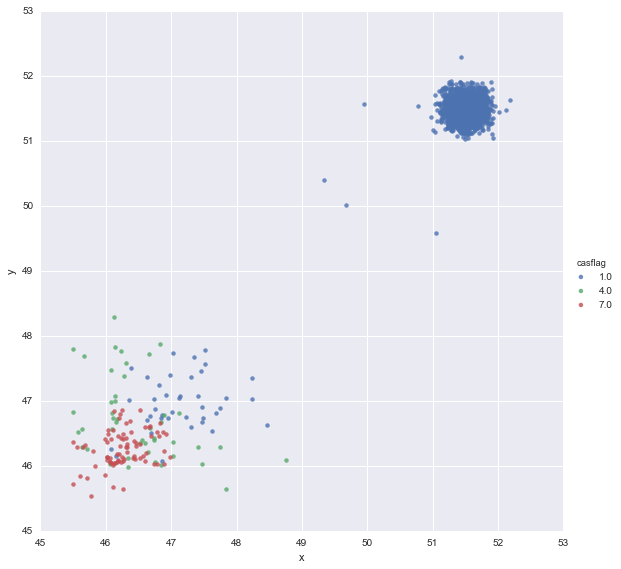

In [5]:
sb.lmplot('x', 'y', hue='casflag', data=data_iraf, 
          fit_reg=False, size=8)

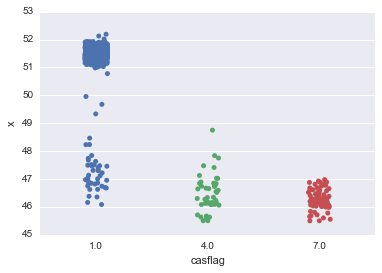

In [6]:
sb.stripplot('casflag', 'x', data=data_iraf, jitter=True)

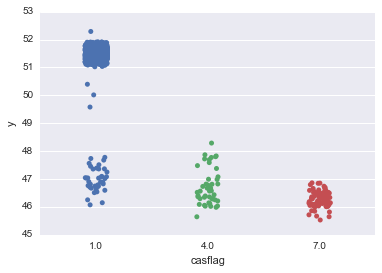

In [7]:
sb.stripplot('casflag', 'y', data=data_iraf, jitter=True)

Most of the values with weird behavior have indeed been flagged as such, but there are still a few outliers with `casflag = 1`.

In [8]:
cas1 = data_iraf.casflag == 1
good = cas1 & (data_iraf.x > 50.5) & (data_iraf.y > 50.5)
outliers = cas1 & (data_iraf.x < 50.5) & (data_iraf.y < 50.5)

print("There are {0} values flagged as OK".format(cas1.sum()),
      "with {0} outliers,".format(outliers.sum()),
      "that is {0}%.".format(round(outliers.sum()/good.sum() * 100, 2)))

There are 1439 values flagged as OK with 41 outliers, that is 2.94%.


### Load `galSVM` morpho catalogue

In [9]:
data_idl = fits.getdata('../catalogs/vis_8b-sc_cat_morpho.fit', 1)

# from astropy.table import Table
# data_idl = Table.read('../catalogs/vis_8b-sc_cat_morpho.fit')

Create sub-samples using the `casflag`.

In [10]:
iraf_cas1 = data_iraf[cas1.values]
idl_cas1 = data_idl[cas1.values]
iraf_out = data_iraf[outliers.values]
idl_out = data_idl[outliers.values]

### Gini index

(0, 1)

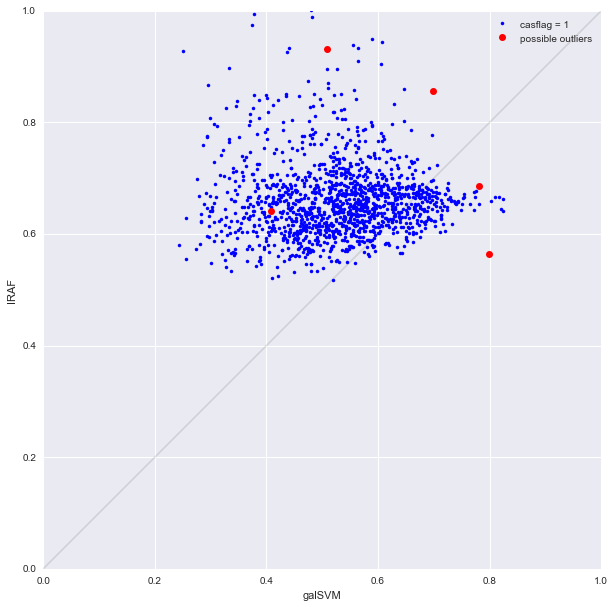

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([0, 1], [0, 1], 'k', alpha=0.1)
ax.plot(idl_cas1.field('GINI'), iraf_cas1.gini, '.b', label='casflag = 1')
ax.plot(idl_out.field('GINI'), iraf_out.gini, 'or', label='possible outliers')
ax.legend()
ax.set_xlabel('galSVM')
ax.set_ylabel('IRAF')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

## $M_{20}$

(-5, 0)

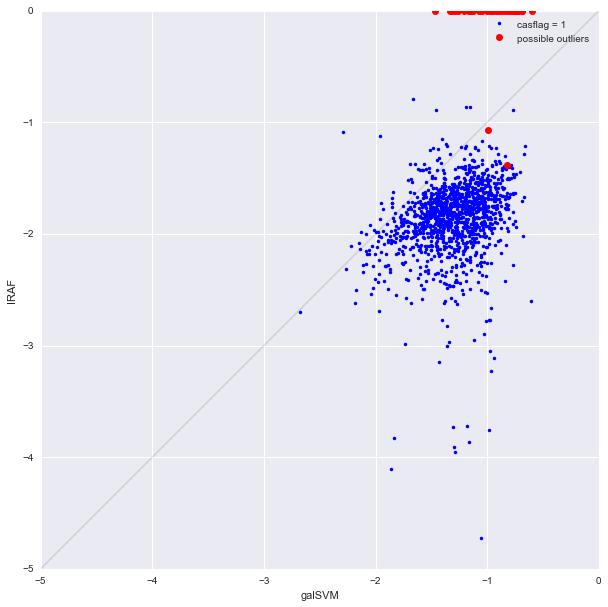

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([-5, 0], [-5, 0], 'k', alpha=0.1)
ax.plot(idl_cas1.field('M20'), iraf_cas1.m20, '.b', label='casflag = 1')
ax.plot(idl_out.field('M20'), iraf_out.m20, 'or', label='possible outliers')
ax.legend()
ax.set_xlabel('galSVM')
ax.set_ylabel('IRAF')
ax.set_xlim([-5,0])
ax.set_ylim([-5,0])

### Concentration

(0, 5)

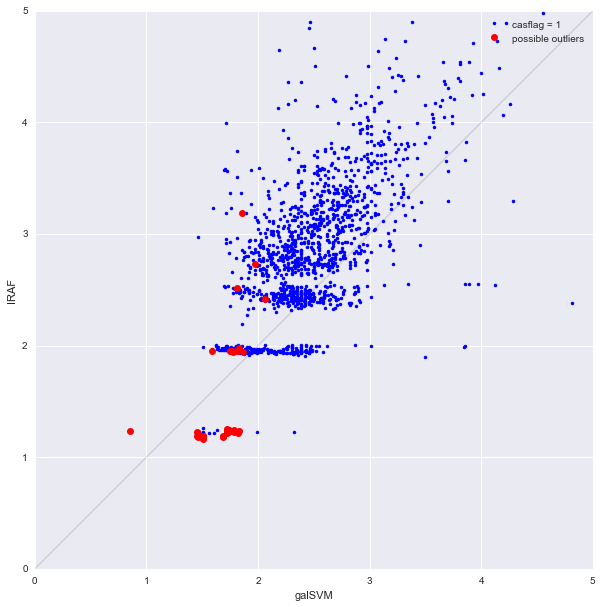

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([-5, 5], [-5, 5], 'k', alpha=0.1)
ax.plot(idl_cas1.field('CCON'), iraf_cas1.c, '.b', label='casflag = 1')
ax.plot(idl_out.field('CCON'), iraf_out.c, 'or', label='possible outliers')
ax.legend()
ax.set_xlabel('galSVM')
ax.set_ylabel('IRAF')
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

### Asymmetry

(-1, 1)

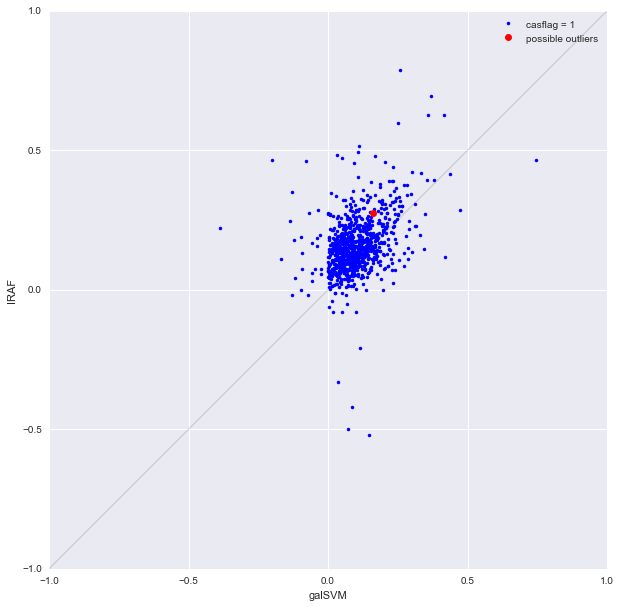

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([-5, 5], [-5, 5], 'k', alpha=0.1)
ax.plot(idl_cas1.field('ASYM'), iraf_cas1.a, '.b', label='casflag = 1')
ax.plot(idl_out.field('ASYM'), iraf_out.a, 'or', label='possible outliers')
ax.legend()
ax.set_xlabel('galSVM')
ax.set_ylabel('IRAF')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

### Smoothness

(-0.5, 0.5)

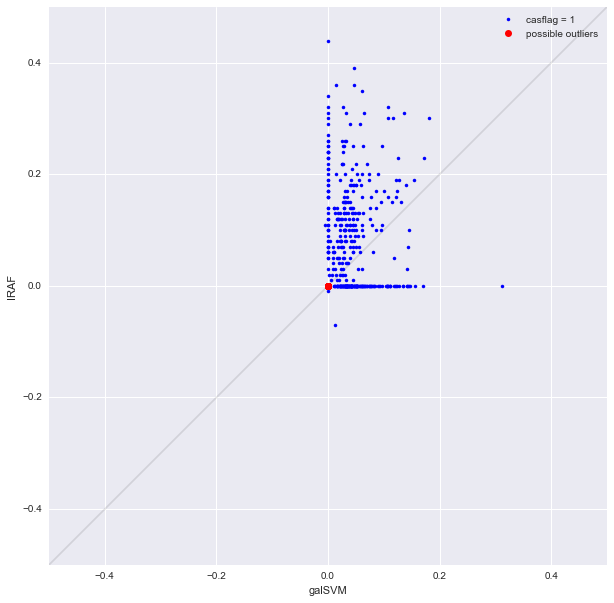

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([-5, 5], [-5, 5], 'k', alpha=0.1)
ax.plot(idl_cas1.field('SMOOTH'), iraf_cas1.s, '.b', label='casflag = 1')
ax.plot(idl_out.field('SMOOTH'), iraf_out.s, 'or', label='possible outliers')
ax.legend()
ax.set_xlabel('galSVM')
ax.set_ylabel('IRAF')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])